<b>
<p>
<center>
<font size="5">
ML (6202_10) Fall 2020 Final Project 
</font>
</center>
</p>

<p>
<center>
<font size='3'>
Jiachen Li, Chaelin Shin, Yushuang (Zoey) Zhao
</font>
</center>
</p>



# Introduction


<p>
<font size='3'>
This project is based on a Kaggle competition (https://www.kaggle.com/c/humpback-whale-identification) and it is about identifying the type of a humpback whale by looking at an image of its tail. In the dataset, there are approximately 20,000 training images and 7,000 test images. The
 number of classes of humpback whales are, in total, 5004, excluding a class named ‘new_whale’, which only means that the type of whale could not be identified; thus, not useful for this project's purposes. 
<p>
</p>
We chose this Kaggle competition because we were fascinated in class to learn about CNNs and its main usage for image classification. Furthermore, we were curious as to whether our codes will work with other datasets, besides the datasets provided by TensorFlow. We also wanted to work on a more complicated dataset where there are images that are much harder to identify, such as in this dataset that only contains images of tails. We thought it would be more difficult to identify a type of whale by looking at its tail compared to identifying, for example, a type of animal by looking at pictures of various animals.
<p>
</p>
For this project, we built a CNN model to identify the type of a humpback whale. As discussed in class, we also used a pretrained model, ResNet50, to speed up the building and training of our model. The pipeline of our project is as the following: 

<p>
</p>
1)	Load “train.csv” file and remove rows with the Id (target variable), “new_whale”;
<p>
</p>
2)	Load images and resize them to (224, 224, 3), which is the required size for ResNet50;
<p>
</p>
3)	Encode labels using integer encoding and one-hot-encoding;
<p>
</p>
4)	Split the training data to training (70%) and validation data (30%); 
<p>
</p>
5)	Build model using ResNet50 and also add some layers on top of that; 
<p>
</p>
6)	Set callbacks;
<p>
</p>
7)	Train model; and
<p>
</p>
8)	Test model.
<p>
</p>

Overall, training accuracy has increased as the number of epochs increased. The training accuracy for the 10th epoch was around 0.99, which is very high. However, there seems to be some discrepancy between training accuracy and validation accuracy with the validation accuracy being a bit higher.
</font>
</p>


# GPU Check

In [ ]:
#check if colab is using GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Notebook Configuration

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/6202 Project Datasets/'


Mounted at /content/drive


In [ ]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [ ]:
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras

In [ ]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [ ]:
# The random seed
random_seed = 24

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

# Data Preprocessing

## Loading Data

### Loading Train.csv

<p>
<font size='3'>
In this section, we load the "train.csv' file as a pandas dataframe. The original file contains 25,361 rows with 2 columns, "Image" and "Id". "Image" is the name of the image file and "Id" is the target variable, which indicates the type of humpback whale. There are 5,005 unique values, or classes, for "Id". And among them, there is an "Id" named "new_whale" which means that the whale in the image cannot be identified. Therefore, we excluded the rows with "new_whale", and the number of remaining rows in the dataset is now 15,697.
</font>
</p>

In [ ]:
# train csv data

# load raw training data
df_raw_train = pd.read_csv( abspath_curr + 'train.csv')

# Make a copy of df_raw_train
df_train = df_raw_train.copy(deep=True)


In [ ]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,25361,2


In [ ]:
# Print the first 5 rows of df_train
df_train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [ ]:
# number of classes
df_train['Id'].nunique()

5005

In [ ]:
# get rid of 'new_whale' (can't identify type of whale)
df_train = df_train[df_train['Id'] != 'new_whale']

In [ ]:
#number of unique classes after removing "new_whale"
df_train['Id'].nunique()

5004

In [ ]:
# create y_train which contains only information of target variable
y_train = df_train["Id"]

y_train.head()

0    w_f48451c
1    w_c3d896a
2    w_20df2c5
6    w_dd88965
8    w_64404ac
Name: Id, dtype: object

### Loading Training Images

<p>
<font size='3'>
Here, we load the 15,697 training images. This part of the code is from https://www.kaggle.com/orhansertkaya/cnn-humpback-whale-identification-with-keras (retrieved 11/25/2020). We went through each image name in df_train and found the corresponding image from the training images folder. Then we added the image one by one to x_train, a numpy array. While loading the images, we also made sure to resize the images to (224, 224, 3), which is the required size to run ResNet50.
</font>
</p>

In [ ]:
from keras.preprocessing import image 
from keras.applications.imagenet_utils import preprocess_input

def prepareTrainImages(train, shape, path):
  
  # create an empty numpy array 
  x_train = np.empty((shape, 224, 224, 3), dtype=np.uint8)
  count = 0

  # iterate through each image in df_train
  for img_name in df_train['Image']:

    # bring image from training folder
    img = image.load_img(abspath_curr + 'training/' + path + img_name, target_size=(224, 224, 3))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    
    # add image to x_train
    x_train[count] = x
    
    # show loading process
    if (count%500 == 0):
      print("Processing Image: ", count+1, ", ", img_name)
    count += 1

  return x_train

In [ ]:
# load training images
#IF YOU SEE ERROR MESSAGE WHEN YOU LOAD IMAGES, PLEASE RESTART THE RUNTIME AND TRY AGAIN. GOOGLE DRIVE MAY TIMEOUT AND CAUSE THE ISSUE. 
#DATA LOADING MAY TAKE UP TO 90 MINS TO FINISH
x_train = prepareTrainImages(df_train, df_train.shape[0], "train/")

Processing Image:  1 ,  0000e88ab.jpg
Processing Image:  501 ,  0823f9df3.jpg
Processing Image:  1001 ,  10b694367.jpg
Processing Image:  1501 ,  195805c52.jpg
Processing Image:  2001 ,  21e28ae02.jpg
Processing Image:  2501 ,  2a1146baa.jpg
Processing Image:  3001 ,  32533a7fb.jpg
Processing Image:  3501 ,  3a8173905.jpg
Processing Image:  4001 ,  42f134dea.jpg
Processing Image:  4501 ,  4aa4de13a.jpg
Processing Image:  5001 ,  5297b6c40.jpg
Processing Image:  5501 ,  5b7f0e6e6.jpg
Processing Image:  6001 ,  6311688b7.jpg
Processing Image:  6501 ,  6b29760e3.jpg
Processing Image:  7001 ,  7390cbfab.jpg
Processing Image:  7501 ,  7b949f512.jpg
Processing Image:  8001 ,  83336c385.jpg
Processing Image:  8501 ,  8b369569b.jpg
Processing Image:  9001 ,  92f450203.jpg
Processing Image:  9501 ,  9b984102a.jpg
Processing Image:  10001 ,  a39babc55.jpg
Processing Image:  10501 ,  ab6f8bddd.jpg
Processing Image:  11001 ,  b36da6f7c.jpg
Processing Image:  11501 ,  bb9ffa8b2.jpg
Processing Image

In [ ]:
# print shape of x_train
print("x_train shape: ", x_train.shape)

x_train shape:  (15697, 224, 224, 3)


<function matplotlib.pyplot.show>

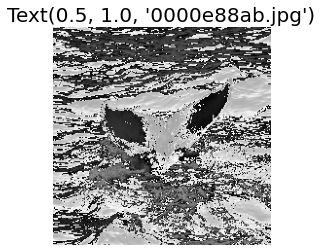

In [ ]:
# make sure the images were loaded properly
plt.imshow(x_train[0][:,:,0], cmap='gray')
plt.title(plt.title(df_train.iloc[0,0]))
plt.axis('off')
plt.show

<function matplotlib.pyplot.show>

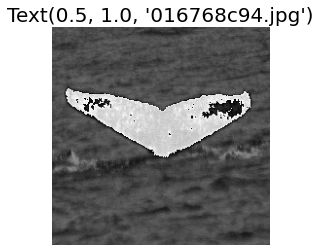

In [ ]:
plt.imshow(x_train[87][:,:,0], cmap='gray')
plt.title(plt.title(df_train.iloc[87,0]))
plt.axis('off')
plt.show

<function matplotlib.pyplot.show>

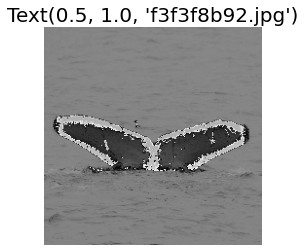

In [ ]:
plt.imshow(x_train[15000][:,:,0], cmap='gray')
plt.title(plt.title(df_train.iloc[15000,0]))
plt.axis('off')
plt.show

### Loading Test Images

<p>
<font size='3'>
Here, we load the 7,960 test images from the test folder. This part of the code is also from https://www.kaggle.com/orhansertkaya/cnn-humpback-whale-identification-with-keras (retrieved 11/25/2020). We first create a pandas dataframe called df_test and create two columns, "Image" and "Id". However, we leave the "Id" column empty, of course, so that we can later add the predicted Id's after running the model.
<p>
</p>
Then we load the test images. Again, we resize the images to (224, 224, 3) and add the images to x_test, another numpy array.
</font>
</p>

In [ ]:
# bring test data from folder
testdata = os.listdir(abspath_curr + "test/")
print(len(testdata))

7960


In [ ]:
# create df_test with two columns, "Image" and "Id"
column = ['Image']
df_test = pd.DataFrame(testdata, columns=column)
df_test['Id'] = ''
df_test.shape

(7960, 2)

In [ ]:
def prepareTestImages(test, shape,path):
 
  # create an empty numpy array 
  x_test = np.empty((shape, 224, 224, 3), dtype=np.uint8)
  count = 0

  # iterate through image in df_test
  for img_name in df_test['Image']:
    img = image.load_img(abspath_curr + 'test/' + img_name, target_size=(224, 224, 3))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    
    # add image to x_test
    x_test[count] = x

    # show loading process
    if (count%500 == 0):
      print("Processing Image: ", count+1, ", ", img_name)
    count += 1

  return x_test

In [ ]:
# load test images
#IF YOU SEE ERROR MESSAGE WHEN YOU LOAD IMAGES, PLEASE RESTART THE RUNTIME AND TRY AGAIN. GOOGLE DRIVE MAY TIMEOUT AND CAUSE THE ISSUE. 
#DATA LOADING MAY TAKE UP TO ONE HOUR
x_test = prepareTestImages(df_test, df_test.shape[0],'test/')  

Processing Image:  1 ,  dec92d888.jpg
Processing Image:  501 ,  f15cc97a7.jpg
Processing Image:  1001 ,  bf42cdb63.jpg
Processing Image:  1501 ,  cf0b1d881.jpg
Processing Image:  2001 ,  9e824b098.jpg
Processing Image:  2501 ,  b015ae8e2.jpg
Processing Image:  3001 ,  7efc384cb.jpg
Processing Image:  3501 ,  8e65249c1.jpg
Processing Image:  4001 ,  5f93559ca.jpg
Processing Image:  4501 ,  6fb019d0e.jpg
Processing Image:  5001 ,  3e697b323.jpg
Processing Image:  5501 ,  4e9806396.jpg
Processing Image:  6001 ,  1c19dcd4f.jpg
Processing Image:  6501 ,  2dcb8578c.jpg
Processing Image:  7001 ,  000e7c7df.jpg
Processing Image:  7501 ,  0fbe7a441.jpg


In [ ]:
# check length of x_test
len(x_test)

7960

## Label Encoding

<p>
<font size='3'>
In this section, we encode the labels in y_train, which contains the "Id" values. Since the "Id" label is a complex combination of both alphabets and numbers, we implemented integer encoding and one-hot encoding. This part of the code is also based on https://www.kaggle.com/orhansertkaya/cnn-humpback-whale-identification-with-keras (retrieved 11/25/2020).
</font>
</p>

In [ ]:
# integer encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)

In [ ]:
# look at first 10 values
y_train[0:10]

array([4785, 3807,  661, 4314, 1928, 3236, 1710, 3942, 4110, 2721])

In [ ]:
# convert to one-hot-encoding(one hot vectors)
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 5004) 

In [ ]:
# print shape of y_train
print(y_train.shape)
y_train

(15697, 5004)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Getting Training and Validation Data

<p>
<font size='3'>
Here, we split the training data to training data (70%) and validation data (30%). Therefore, we now have train_x, train_y, val_x, and val_y.
</font>
</p>

In [ ]:
# create validation set (30%)
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size=0.30,random_state=24)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((10987, 224, 224, 3), (10987, 5004)), ((4710, 224, 224, 3), (4710, 5004)))

<function matplotlib.pyplot.show>

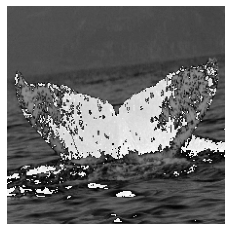

In [ ]:
# check whether images were loaded properly
plt.imshow(val_x[2][:,:,0], cmap='gray')
plt.axis('off')
plt.show

## Creating directory for the model


In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/model/')
if not os.path.exists(directory):
    os.makedirs(directory)

# Building Model

<p>
<font size='3'>
In this section, we apply transfer learning by utilizing a pretrained model, ResNet50, from Keras application. Then we add a fully connected layer after ResNet50. We also set callbacks as we did in class.
<p>
</p>
This part of the codes is based on:

- https://github.com/yuxiaohuang/teaching/blob/master/gwu/machine_learning_I/fall_2020/code/p3_deep_learning/p3_c2_supervised_learning/p3_c2_s3_convolutional_neural_networks/case_study/case_study.ipynb (retrieved 11/29/2020); and
- https://www.kaggle.com/orhansertkaya/cnn-humpback-whale-identification-with-keras (retrieved 11/29/2020).
</font>
</p>




### Building Model with ResNet50

In [ ]:
from keras.applications.resnet50 import ResNet50, decode_predictions
from keras.models import Sequential
from keras.layers import Input,Dense, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout

In [ ]:
num_classes = 5004

In [ ]:
#create a sequential model
model = Sequential()

#add ResNet50 pretrained layers to the model 
model.add(ResNet50(
    include_top = False,
    pooling = 'avg',
    weights = 'imagenet',
   input_shape=(224,224, 3)
))

# fully connected (dense) layer
model.add(Dense(256,activation= 'relu'))
model.add(BatchNormalization())

#add output layer 
model.add(Dense(num_classes,activation='softmax'))

#check model structure 
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_26 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_27 (Dense)             (None, 5004)              1286028   
Total params: 25,399,308
Trainable params: 25,345,676
Non-trainable params: 53,632
_________________________________________________________________


### Setting Callbacks

In [ ]:
#setting callbacks 
# ModelCheckpoint callback 
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/result/model/model.FinalProject',
                                                     save_best_only=True,
                                                     save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                            monitor = 'val_loss',
                                                           patience=3,
                                                           verbose = 1)
                                                            

### Compiling Model

In [ ]:
#compile model with small learning rate
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#assign 10 epochs to model
num_epochs = 10

#Training Model

### Training

In [ ]:
history = model.fit(x_train, y_train,
                    epochs = num_epochs,
                    verbose=2,
                    validation_data= (val_x,val_y),
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/10
491/491 - 59s - loss: 8.3834 - accuracy: 0.0144 - val_loss: 7.8323 - val_accuracy: 0.0439
Epoch 2/10
491/491 - 57s - loss: 7.6099 - accuracy: 0.0580 - val_loss: 6.9551 - val_accuracy: 0.0854
Epoch 3/10
491/491 - 57s - loss: 6.7185 - accuracy: 0.1140 - val_loss: 5.9975 - val_accuracy: 0.1573
Epoch 4/10
491/491 - 58s - loss: 5.8244 - accuracy: 0.2018 - val_loss: 5.1115 - val_accuracy: 0.2696
Epoch 5/10
491/491 - 57s - loss: 4.8866 - accuracy: 0.3254 - val_loss: 4.0729 - val_accuracy: 0.4541
Epoch 6/10
491/491 - 57s - loss: 3.9398 - accuracy: 0.5037 - val_loss: 3.0705 - val_accuracy: 0.6720
Epoch 7/10
491/491 - 57s - loss: 3.0286 - accuracy: 0.7064 - val_loss: 2.1615 - val_accuracy: 0.8335
Epoch 8/10
491/491 - 57s - loss: 2.2056 - accuracy: 0.8656 - val_loss: 1.3801 - val_accuracy: 0.9631
Epoch 9/10
491/491 - 58s - loss: 1.4922 - accuracy: 0.9581 - val_loss: 0.7471 - val_accuracy: 0.9898
Epoch 10/10
491/491 - 57s - loss: 0.9233 - accuracy: 0.9906 - val_loss: 0.4569 - val_accura


<p>
<font size='3'>
As you can see from the model result, this model is slightly underfitting, which means the model is not learning images' features very well. We have tried to add more parameters, layers, and epochs to the model, but it still has not solved the underfitting problem. 
</font>
</p>


### Plotting Learning Curve

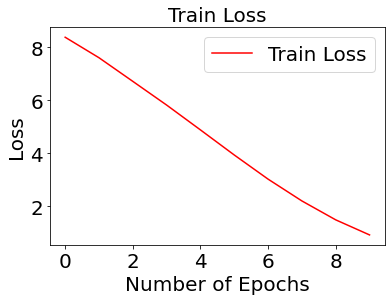

In [ ]:
# train loss
plt.plot(history.history['loss'], color='red', label = 'Train Loss')
plt.title('Train Loss')
plt.xlabel('Number of Epochs')
plt.ylabel("Loss")
plt.legend()
plt.show()

<p>
<font size='3'>
From the above graph, the training loss decreased rapidly as the number of epochs increased. 
</font>
</p>

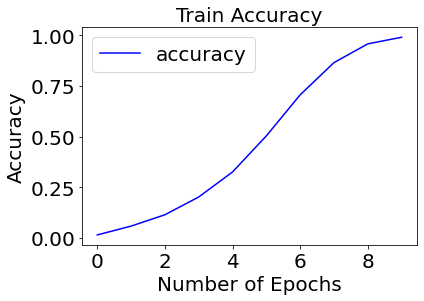

In [ ]:
# train accuracy
plt.plot(history.history['accuracy'], color='blue', label="accuracy")
plt.title('Train Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<p>
<font size='3'>
Based on the training accuracy plot, the model accuracy has reached to almost 100% after 8 epochs. 
</font>
</p>

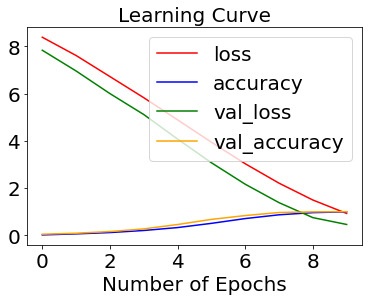

In [ ]:
plt.plot(history.history['loss'], color='red', label = 'loss')
plt.plot(history.history['accuracy'], color='blue', label="accuracy")
plt.plot(history.history['val_loss'], color='green', label="val_loss")
plt.plot(history.history['val_accuracy'], color='orange', label="val_accuracy")
plt.title("Learning Curve")
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

# Testing (Predictions)

<p>
<font size='3'>
After training our model, we now predict the Id's (type of whale) by looking at the test images. We fill in the Id's in df_test and save it as a separate csv file.
</font>
</p>

In [ ]:
# predict 7960 images
predictions = model.predict(np.array(x_test), batch_size = 1, verbose=1)

7960/7960 [==============================] - 46s 6ms/step


In [ ]:
for i, pred in enumerate(predictions):
    df_test.loc[i, 'Id'] = ' '.join(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))

In [ ]:
# look at the first 20 rows
#df_test.head(20)

In [ ]:
#save prediction result in the drive 
from google.colab import  drive

#drive.mount('/drive')
df_test.to_csv( abspath_curr + 'result/Submission.csv')

# Conclusion

<p>
<font size='3'>
Overall, we were successful in training our model with more than 15,000 images, and, eventually, predicting the type of whale in the test images. We were able to build a simple model using ResNet50, and, achieve accuracy of almost 1 by only after 10 epochs. 
<p>
</p>
However, our model seems to be a bit underfitting, since validation accuracy is constantly higher than training accuracy in each epoch. It would have been a better model if we had found a way to resolve the underfitting problem, although we did our best to fine-tune the model. 
</font>
</p>

# References

<p>
<font size='3'>
The codes in our project are based on codes from the following sources: 

- https://github.com/yuxiaohuang/teaching/blob/master/gwu/machine_learning_I/fall_2020/code/p3_deep_learning/p3_c2_supervised_learning/p3_c2_s3_convolutional_neural_networks/case_study/case_study.ipynb
- https://www.kaggle.com/orhansertkaya/cnn-humpback-whale-identification-with-keras
- https://hjweide.github.io/efficient-image-loading
- https://medium.com/@nina95dan/simple-image-classification-with-resnet-50-334366e7311a </font>
</p>